<a href="https://colab.research.google.com/github/manyamule/WCEHackathon2025_Introspectors/blob/main/Isolation_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount drive

from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scikit-learn pandas numpy matplotlib seaborn


In [ ]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Create directories for saving outputs
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('reports', exist_ok=True)

print("Environment set up complete!")

Environment set up complete!


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data from CSV with flexible date parsing
def load_data(csv_path):
    print(f"Loading data from: {csv_path}")

    # First, try to determine if the file is tab-separated or comma-separated
    with open(csv_path, 'r') as f:
        first_line = f.readline().strip()
        if '\t' in first_line:
            print("Detected tab-separated file")
            df = pd.read_csv(csv_path, sep='\t')
        else:
            print("Assuming comma-separated file")
            df = pd.read_csv(csv_path)

    print(f"Raw data shape: {df.shape}")
    print("Column names:", df.columns.tolist())
    print("\nFirst 3 rows of raw data:")
    print(df.head(3))

    # Convert datetime column to datetime type and set as index
    if 'dt_time' in df.columns:
        # Try to parse dates with pandas' flexible parser
        print("\nConverting dates to datetime format...")
        df['dt_time'] = pd.to_datetime(df['dt_time'], infer_datetime_format=True)
        df.set_index('dt_time', inplace=True)

    print(f"\nProcessed data shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")

    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing values per column:")
        print(missing[missing > 0])

    return df

# Load air quality data
data = load_data('/content/drive/MyDrive/WCE/air_quality_data.csv')

# Display first few rows of processed data
print("\nFirst 5 rows of processed data:")
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from: /content/drive/MyDrive/WCE/air_quality_data.csv
Assuming comma-separated file
Raw data shape: (3356255, 4)
Column names: ['dt_time', 'pm2.5cnc', 'pm10cnc', 'deviceid']

First 3 rows of raw data:
               dt_time  pm2.5cnc  pm10cnc  deviceid
0  2023-12-29 00:00:00    170.58   260.87  site_104
1  2023-12-29 00:15:00    164.56   279.53  site_104
2  2023-12-29 00:30:00    186.15   296.75  site_104

Converting dates to datetime format...

Processed data shape: (3356255, 3)
Date range: 2023-12-29 00:00:00 to 2024-12-31 00:00:00

Missing values per column:
pm2.5cnc    568730
pm10cnc     577798
dtype: int64

First 5 rows of processed data:


,pm2.5cnc,pm10cnc,deviceid
dt_time,,,
2023-12-29 00:00:00,170.58,260.87,site_104
2023-12-29 00:15:00,164.56,279.53,site_104
2023-12-29 00:30:00,186.15,296.75,site_104
2023-12-29 00:45:00,205.22,318.59,site_104
2023-12-29 01:00:00,211.11,334.24,site_104


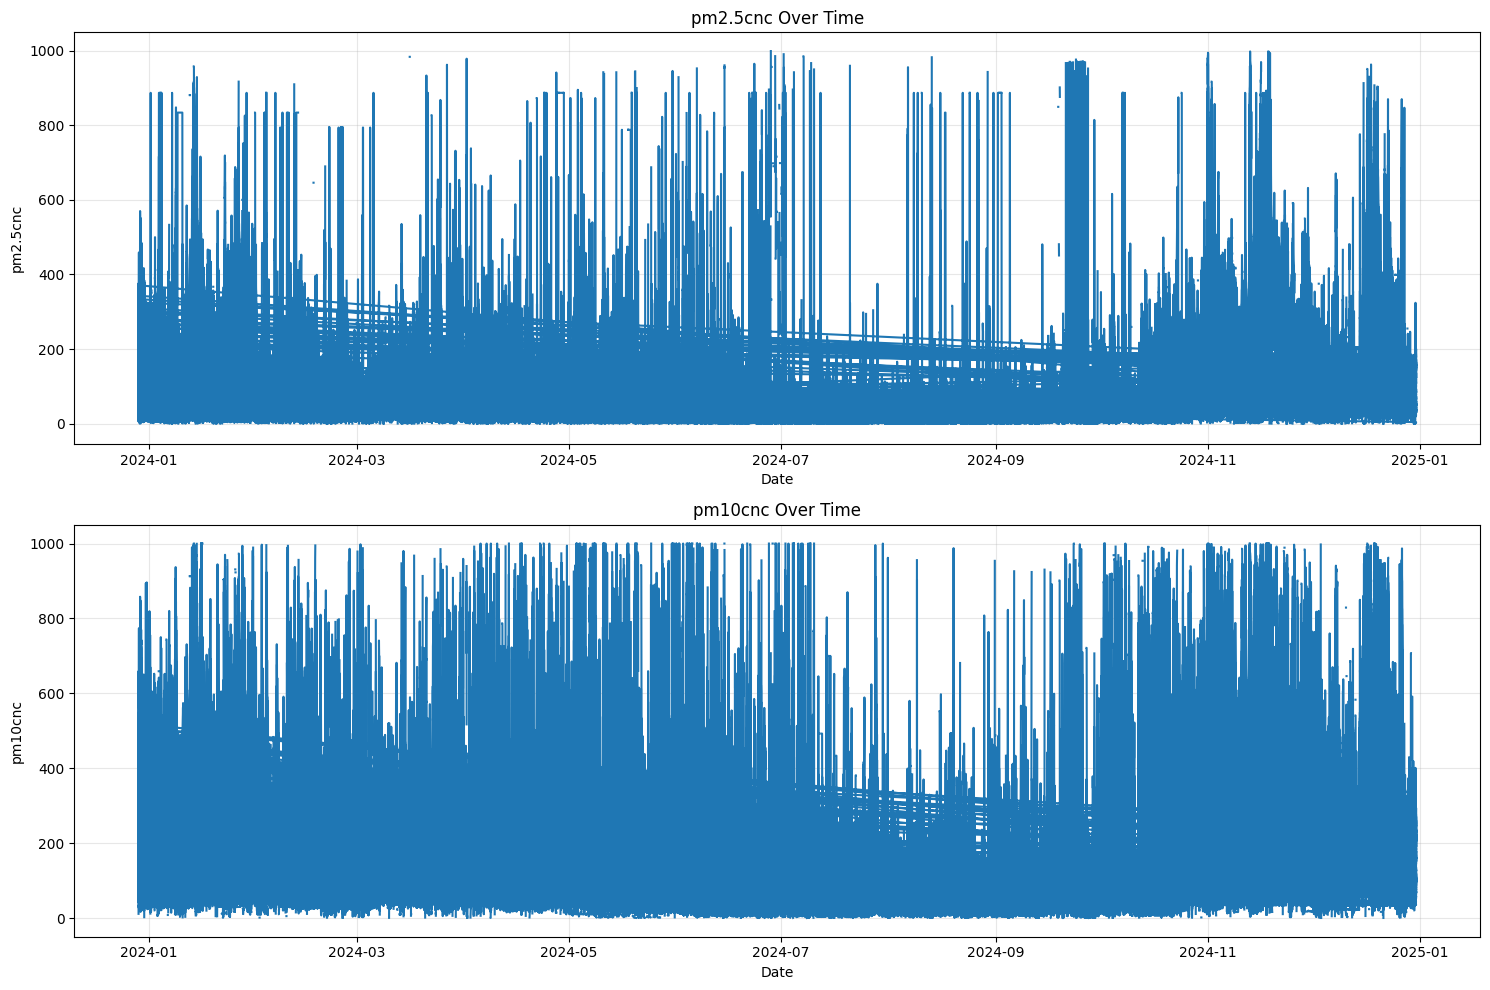

Data visualization complete!


In [ ]:
# Visualize the data to understand its characteristics
def plot_air_quality_data(df, parameters):
    """Plot the air quality parameters over time."""
    plt.figure(figsize=(15, 5 * len(parameters)))

    for i, param in enumerate(parameters):
        if param in df.columns:
            plt.subplot(len(parameters), 1, i+1)
            plt.plot(df.index, df[param])
            plt.title(f'{param} Over Time')
            plt.xlabel('Date')
            plt.ylabel(param)
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('plots/air_quality_overview.png')
    plt.show()

# Plot PM2.5 and PM10 concentrations
params = ['pm2.5cnc', 'pm10cnc']
plot_air_quality_data(data, params)

print("Data visualization complete!")

In [ ]:
def preprocess_data(df, params=None, resample=True, resample_freq='1h', train_ratio=0.8):
    """
    Preprocess the air quality data:
    - Select specific parameters
    - Handle missing values
    - Resample to regular intervals
    - Split into train/test sets
    """
    print("Starting data preprocessing...")

    # Select parameters if provided
    if params and all(param in df.columns for param in params):
        print(f"Selecting parameters: {params}")
        df = df[params]

    # Handle missing values
    if df.isnull().sum().sum() > 0:
        print(f"Handling {df.isnull().sum().sum()} missing values")
        df.ffill(inplace=True)  # Forward fill
        df.bfill(inplace=True)  # Backward fill

    # Resample data if needed
    if resample:
        print(f"Resampling data to {resample_freq}")
        df = df.resample(resample_freq).mean()
        df.ffill(inplace=True)
        df.bfill(inplace=True)

    # Time-based train-test split
    print(f"Performing time-based train-test split with ratio {train_ratio}")
    split_idx = int(len(df) * train_ratio)
    train_data = df.iloc[:split_idx]
    test_data = df.iloc[split_idx:]

    print(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")
    return df, train_data, test_data

# Preprocess the data
preprocessed_data, train_data, test_data = preprocess_data(
    data,
    params=params,
    resample=True,
    resample_freq='1h',
    train_ratio=0.8
)

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

print("Data preprocessing complete!")
print("\nPreprocessed data (hourly averages):")
preprocessed_data.head()

Starting data preprocessing...
Selecting parameters: ['pm2.5cnc', 'pm10cnc']
Handling 1146528 missing values
Resampling data to 1h
Performing time-based train-test split with ratio 0.8
Train data shape: (7066, 2), Test data shape: (1767, 2)
Data preprocessing complete!

Preprocessed data (hourly averages):


,pm2.5cnc,pm10cnc
dt_time,,
2023-12-29 00:00:00,127.568579,217.236579
2023-12-29 01:00:00,127.819000,220.494658
2023-12-29 02:00:00,124.464000,213.474184
2023-12-29 03:00:00,120.631447,208.380921
2023-12-29 04:00:00,117.210395,200.544342


In [ ]:
def create_isolation_forest(n_estimators=100, contamination='auto', random_state=42):
    """
    Create an Isolation Forest model for anomaly detection.

    Args:
        n_estimators: Number of estimators/trees
        contamination: Expected proportion of outliers
        random_state: Random seed for reproducibility
    """
    model = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=random_state,
        n_jobs=-1  # Use all processors
    )
    return model

# Create and train the Isolation Forest model
print("Creating and training Isolation Forest model...")
isolation_forest = create_isolation_forest(n_estimators=100, contamination='auto')
isolation_forest.fit(scaled_train)

# Save the model
import joblib
joblib.dump(isolation_forest, 'models/isolation_forest.joblib')
joblib.dump(scaler, 'models/isolation_forest_scaler.joblib')
print("Model saved to 'models/isolation_forest.joblib'")
print("Scaler saved to 'models/isolation_forest_scaler.joblib'")

Creating and training Isolation Forest model...
Model saved to 'models/isolation_forest.joblib'
Scaler saved to 'models/isolation_forest_scaler.joblib'


In [ ]:
# Detect anomalies in the test data
def detect_anomalies(model, data, threshold=None):
    """
    Detect anomalies using a fitted Isolation Forest model.

    Args:
        model: Trained Isolation Forest model
        data: Scaled data to detect anomalies in
        threshold: Optional custom threshold (if None, use model's default)

    Returns:
        anomaly_scores: Raw anomaly scores
        anomalies: Boolean array of anomalies
    """
    # Get anomaly scores
    # Note: The decision_function gives the negative of the anomaly score
    # Lower (more negative) values are more anomalous
    anomaly_scores = -model.decision_function(data)  # Negate so higher = more anomalous

    # Get binary predictions (1: inlier, -1: outlier)
    raw_predictions = model.predict(data)

    # Convert to boolean array (True for anomalies)
    anomalies = raw_predictions == -1

    return anomaly_scores, anomalies

# Detect anomalies in the test set
print("Detecting anomalies in the test data...")
test_scores, test_anomalies = detect_anomalies(isolation_forest, scaled_test)

# Create a DataFrame with the results
results = pd.DataFrame(index=test_data.index)
results['anomaly_score'] = test_scores
results['anomaly'] = test_anomalies

# Add original data for reference
for col in test_data.columns:
    results[col] = test_data[col].values

# Calculate anomaly statistics
anomaly_count = results['anomaly'].sum()
total_points = len(results)
anomaly_percent = (anomaly_count / total_points) * 100

print(f"Detected {anomaly_count} anomalies out of {total_points} points ({anomaly_percent:.2f}%)")

# Save results to CSV
results.to_csv('reports/isolation_forest_anomalies.csv')
print("Results saved to 'reports/isolation_forest_anomalies.csv'")

# Display results
print("\nDetection results:")
results

Detecting anomalies in the test data...
Detected 1282 anomalies out of 1767 points (72.55%)
Results saved to 'reports/isolation_forest_anomalies.csv'

Detection results:


,anomaly_score,anomaly,pm2.5cnc,pm10cnc
dt_time,,,,
2024-10-18 10:00:00,0.009904,True,70.053553,168.432684
2024-10-18 11:00:00,-0.039537,False,61.615579,154.276921
2024-10-18 12:00:00,-0.067768,False,48.537105,129.464132
2024-10-18 13:00:00,-0.073341,False,42.861289,114.952000
2024-10-18 14:00:00,-0.073886,False,39.351105,107.666289
...,...,...,...,...
2024-12-30 20:00:00,-0.000770,False,71.093237,135.954053
2024-12-30 21:00:00,-0.000191,False,71.267763,135.726921
2024-12-30 22:00:00,0.009501,True,73.687553,138.009342


Generating anomaly plots...


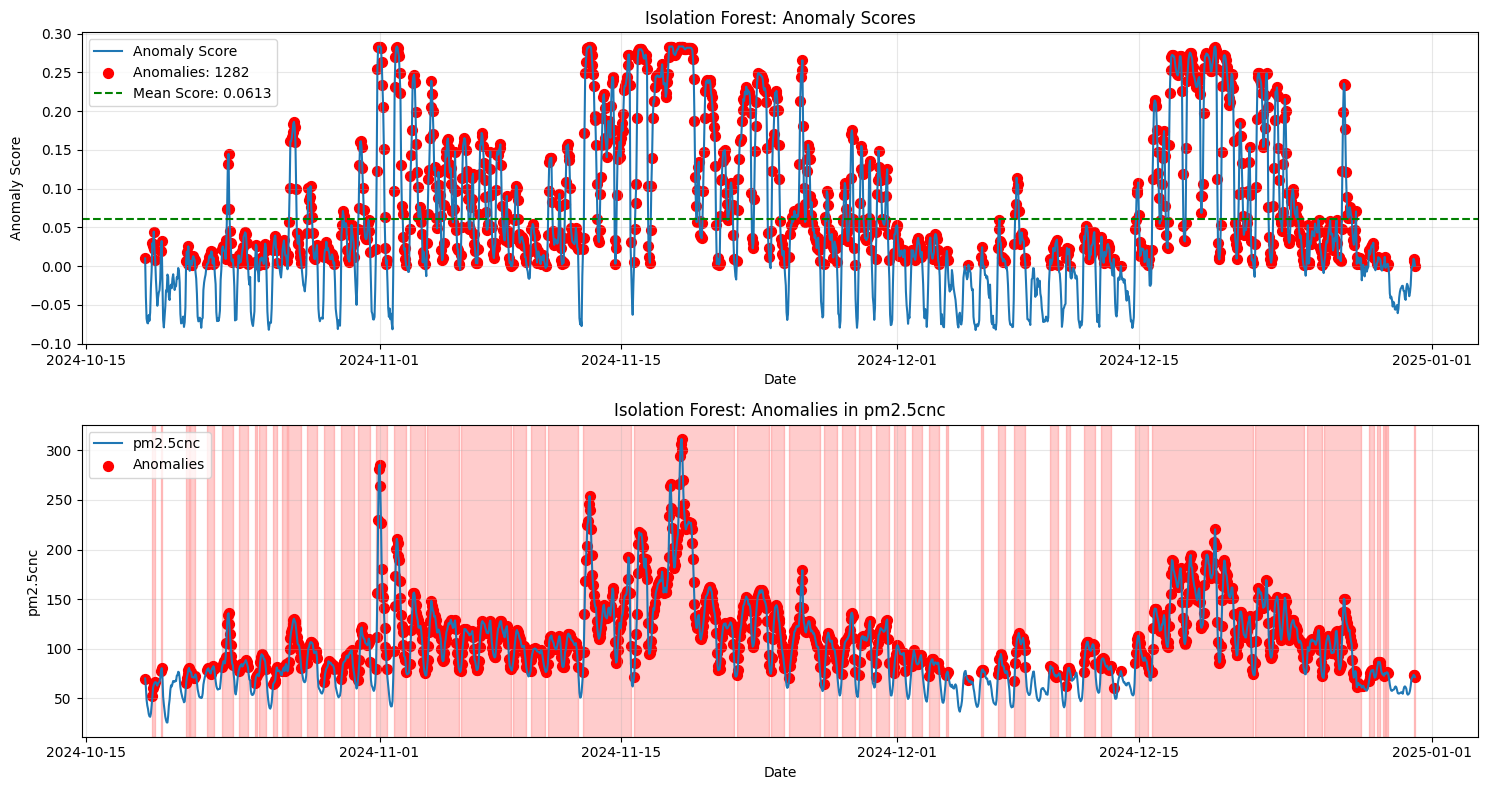

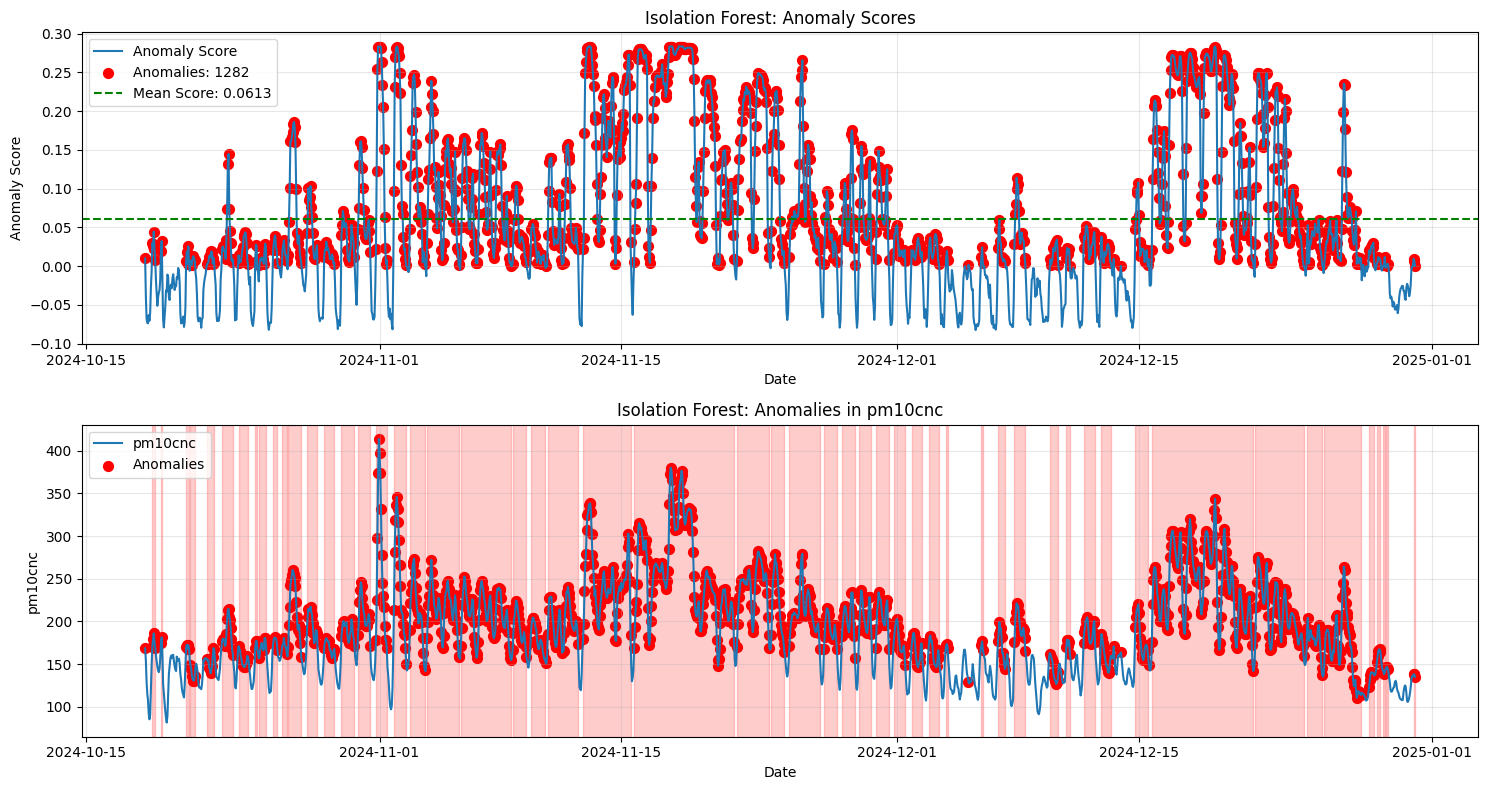

Anomaly visualization complete!


In [ ]:
def plot_anomalies(results, parameter, model_name='Isolation Forest'):
    """
    Plot the original time series with anomalies highlighted.

    Args:
        results: DataFrame with anomaly results
        parameter: Parameter to plot
        model_name: Name of the model
    """
    plt.figure(figsize=(15, 8))

    # Plot 1: Anomaly scores
    plt.subplot(2, 1, 1)
    plt.plot(results.index, results['anomaly_score'], label='Anomaly Score')

    # Highlight anomalies in the score plot
    anomalies = results[results['anomaly']]
    if not anomalies.empty:
        plt.scatter(anomalies.index, anomalies['anomaly_score'],
                    color='red', label=f'Anomalies: {len(anomalies)}', s=50)

    # Add a horizontal line at the average anomaly score
    mean_score = results['anomaly_score'].mean()
    plt.axhline(y=mean_score, color='green', linestyle='--',
                label=f'Mean Score: {mean_score:.4f}')

    plt.title(f'{model_name}: Anomaly Scores')
    plt.xlabel('Date')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Original time series with anomalies highlighted
    plt.subplot(2, 1, 2)
    plt.plot(results.index, results[parameter], label=parameter)

    # Highlight anomalies
    if not anomalies.empty:
        plt.scatter(anomalies.index, anomalies[parameter],
                   color='red', label='Anomalies', s=50)

        # Optionally highlight continuous anomaly segments
        anomalies['date'] = anomalies.index
        try:
            anomalies['group'] = (anomalies['date'].diff() > pd.Timedelta('1h')).cumsum()

            for group, group_data in anomalies.groupby('group'):
                if len(group_data) > 1:  # Only highlight if more than one point
                    start = group_data.index.min()
                    end = group_data.index.max()
                    plt.axvspan(start, end, color='red', alpha=0.2)
        except:
            # If there's only one anomaly, we can't calculate differences
            pass

    plt.title(f'{model_name}: Anomalies in {parameter}')
    plt.xlabel('Date')
    plt.ylabel(parameter)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'plots/{model_name.lower().replace(" ", "_")}_{parameter}_anomalies.png')
    plt.show()

# Plot anomalies for each parameter
print("Generating anomaly plots...")
for param in params:
    plot_anomalies(results, param)
print("Anomaly visualization complete!")

Analyzing anomaly characteristics...

ANOMALY ANALYSIS SUMMARY:
Total points analyzed: 1767
Anomalies detected: 1282 (72.55%)

Parameter: pm2.5cnc
  Normal data: mean = 61.10, std = 10.75
  Anomalous data: mean = 117.60, std = 38.12
  Percent difference: 92.46%
  Standard deviation distance: 5.25 σ


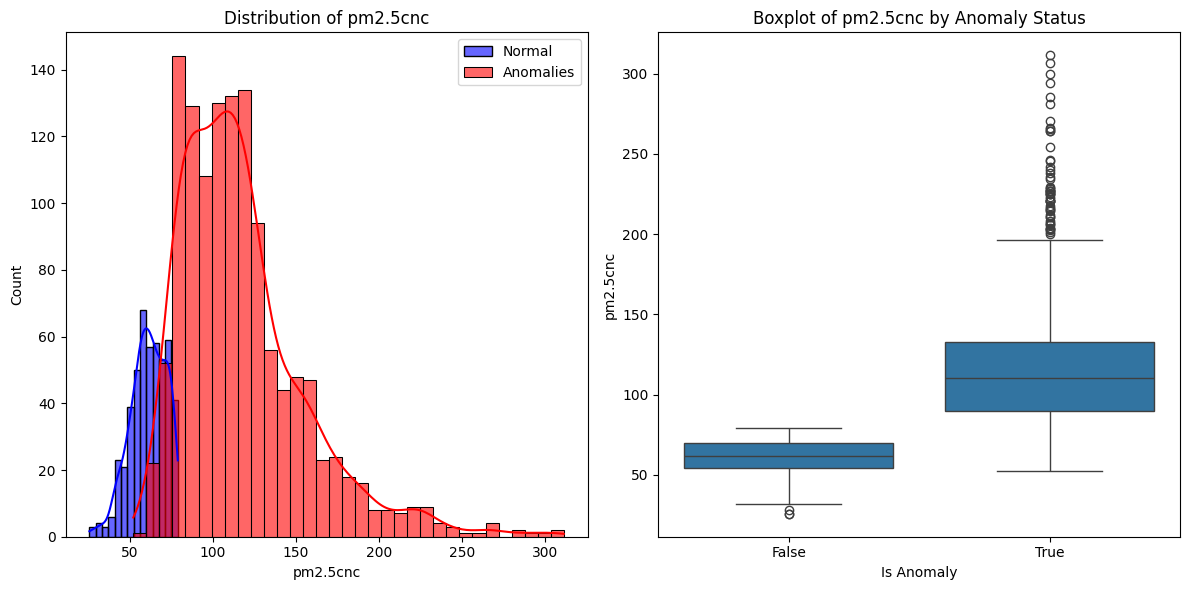


Parameter: pm10cnc
  Normal data: mean = 135.90, std = 17.80
  Anomalous data: mean = 210.95, std = 47.29
  Percent difference: 55.22%
  Standard deviation distance: 4.22 σ


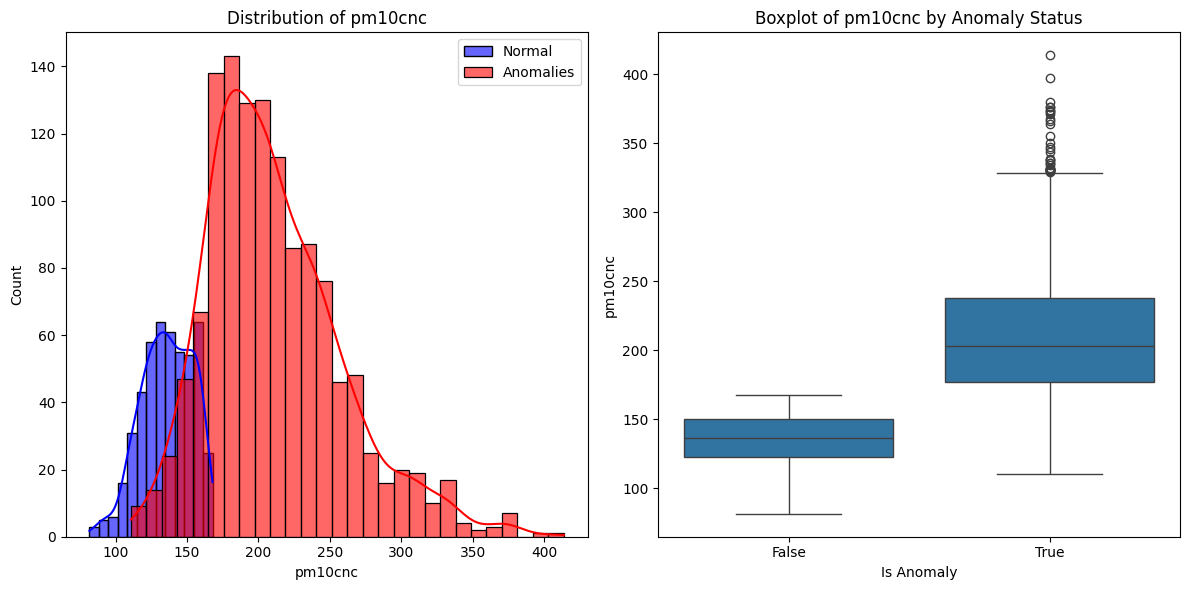


Detected 54 anomaly events (consecutive anomalies)

Analysis saved to 'reports/isolation_forest_analysis.json'


In [ ]:
def analyze_anomaly_characteristics(results, params):
    """
    Analyze the characteristics of detected anomalies.

    Args:
        results: DataFrame with anomaly results
        params: List of parameters to analyze
    """
    # Separate normal and anomalous points
    normal = results[~results['anomaly']]
    anomalies = results[results['anomaly']]

    if anomalies.empty:
        print("No anomalies to analyze.")
        return None

    # Create summary statistics
    summary = {
        "model": "Isolation Forest",
        "total_points": len(results),
        "anomaly_count": len(anomalies),
        "anomaly_percent": (len(anomalies) / len(results)) * 100,
        "parameters": {}
    }

    print("\nANOMALY ANALYSIS SUMMARY:")
    print(f"Total points analyzed: {summary['total_points']}")
    print(f"Anomalies detected: {summary['anomaly_count']} ({summary['anomaly_percent']:.2f}%)")

    # For each parameter, calculate statistics
    for param in params:
        # Calculate statistics for normal vs anomalous points
        normal_mean = normal[param].mean()
        normal_std = normal[param].std()
        anomaly_mean = anomalies[param].mean()
        anomaly_std = anomalies[param].std()

        summary["parameters"][param] = {
            "normal_mean": normal_mean,
            "normal_std": normal_std,
            "anomaly_mean": anomaly_mean,
            "anomaly_std": anomaly_std,
            "percent_difference": ((anomaly_mean - normal_mean) / normal_mean) * 100 if normal_mean != 0 else np.nan,
            "std_distance": abs(anomaly_mean - normal_mean) / normal_std if normal_std != 0 else np.nan
        }

        print(f"\nParameter: {param}")
        print(f"  Normal data: mean = {normal_mean:.2f}, std = {normal_std:.2f}")
        print(f"  Anomalous data: mean = {anomaly_mean:.2f}, std = {anomaly_std:.2f}")

        # Calculate percent difference and standard deviation distance
        if normal_mean != 0:
            percent_diff = ((anomaly_mean - normal_mean) / normal_mean) * 100
            print(f"  Percent difference: {percent_diff:.2f}%")

        if normal_std != 0:
            std_distance = abs(anomaly_mean - normal_mean) / normal_std
            print(f"  Standard deviation distance: {std_distance:.2f} σ")

        # Create distribution comparison plot
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        if len(normal) > 1:  # Need at least 2 points for KDE
            sns.histplot(normal[param], kde=True, color='blue', alpha=0.6, label='Normal')
        else:
            plt.axvline(x=normal[param].iloc[0], color='blue', label='Normal')

        if len(anomalies) > 1:  # Need at least 2 points for KDE
            sns.histplot(anomalies[param], kde=True, color='red', alpha=0.6, label='Anomalies')
        else:
            plt.axvline(x=anomalies[param].iloc[0], color='red', label='Anomaly')

        plt.title(f'Distribution of {param}')
        plt.xlabel(param)
        plt.ylabel('Count')
        plt.legend()

        plt.subplot(1, 2, 2)
        if len(results) >= 4:  # Need at least 4 points for a meaningful boxplot
            sns.boxplot(x='anomaly', y=param, data=results)
            plt.title(f'Boxplot of {param} by Anomaly Status')
            plt.xlabel('Is Anomaly')
            plt.ylabel(param)
        else:
            # Alternative plot for small datasets
            plt.scatter(results['anomaly'], results[param], c=results['anomaly'].map({True: 'red', False: 'blue'}))
            plt.title(f'{param} by Anomaly Status')
            plt.xlabel('Is Anomaly')
            plt.ylabel(param)

        plt.tight_layout()
        plt.savefig(f'plots/isolation_forest_distribution_{param}.png')
        plt.show()

    # Check for clusters of consecutive anomalies
    if len(anomalies) > 1:
        try:
            results['event_group'] = (results['anomaly'].diff() == True).cumsum()
            events = results[results['anomaly']].groupby('event_group')

            events_list = []
            for group, event_data in events:
                if len(event_data) > 1:  # Only consider clusters with multiple points
                    event = {
                        'start': event_data.index.min().strftime('%Y-%m-%d %H:%M'),
                        'end': event_data.index.max().strftime('%Y-%m-%d %H:%M'),
                        'duration_hours': (event_data.index.max() - event_data.index.min()).total_seconds() / 3600,
                        'points_count': len(event_data),
                        'avg_score': event_data['anomaly_score'].mean(),
                        'max_score': event_data['anomaly_score'].max(),
                        'parameters': {}
                    }

                    for param in params:
                        event['parameters'][param] = {
                            'mean': event_data[param].mean(),
                            'max': event_data[param].max(),
                            'min': event_data[param].min()
                        }

                    events_list.append(event)

            summary['events'] = events_list
            print(f"\nDetected {len(events_list)} anomaly events (consecutive anomalies)")
        except:
            summary['events'] = []
            print("\nCould not identify continuous anomaly events")
    else:
        summary['events'] = []

    # Save summary to JSON
    import json
    with open('reports/isolation_forest_analysis.json', 'w') as f:
        json.dump(summary, f, indent=4)

    print("\nAnalysis saved to 'reports/isolation_forest_analysis.json'")
    return summary

# Analyze anomaly characteristics
print("Analyzing anomaly characteristics...")
anomaly_summary = analyze_anomaly_characteristics(results, params)

Analyzing temporal patterns of anomalies...

TEMPORAL PATTERNS OF ANOMALIES:
Peak hour for anomalies: 21:00 (67 anomalies)
Peak day for anomalies: Thursday (187 anomalies)


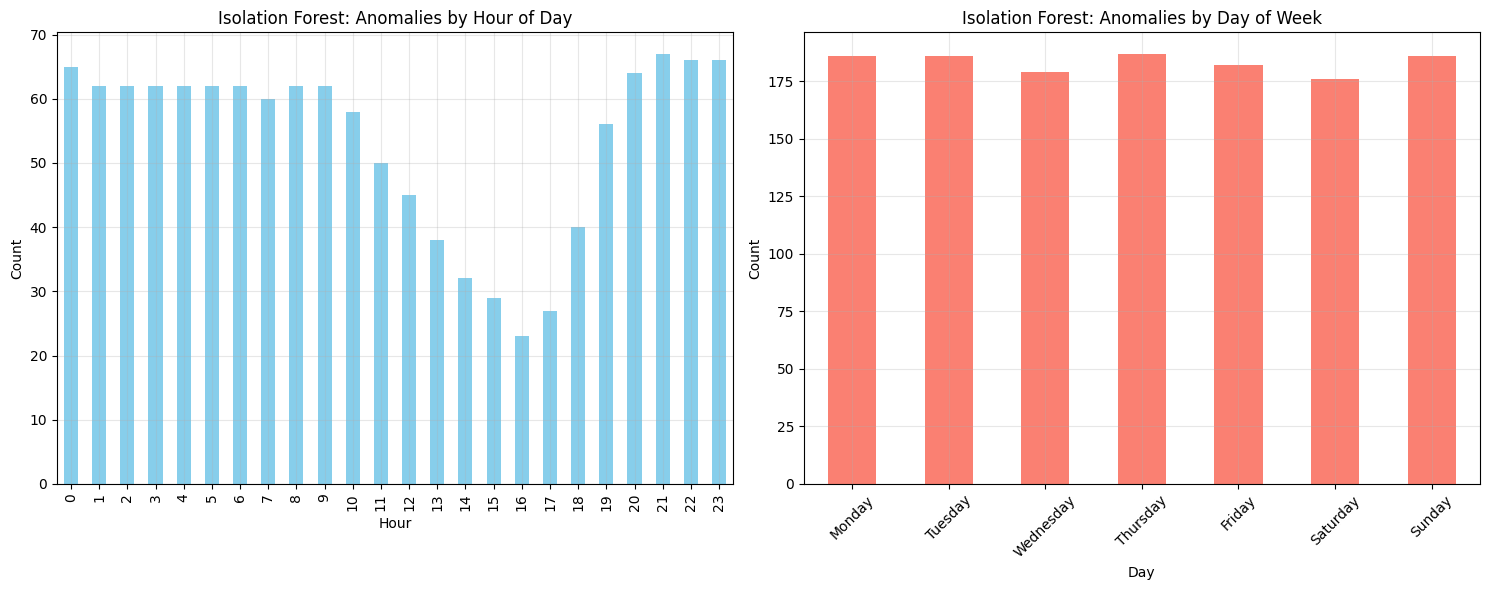

In [ ]:
def analyze_temporal_patterns(anomalies_df, model_name='Isolation Forest'):
    """
    Analyze when anomalies occur (hour of day, day of week).

    Args:
        anomalies_df: DataFrame containing only anomalous points
        model_name: Name of the model
    """
    if anomalies_df.empty:
        print("No anomalies to analyze temporal patterns.")
        return None

    print("\nTEMPORAL PATTERNS OF ANOMALIES:")

    # Check if we have enough data for meaningful patterns
    if len(anomalies_df) < 2:
        print(f"Only {len(anomalies_df)} anomalies detected - not enough for pattern analysis.")
        hours = {anomalies_df.index[0].hour: 1}
        days = {anomalies_df.index[0].dayofweek: 1}

        print(f"Hour of day: {anomalies_df.index[0].hour}:00")
        day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        print(f"Day of week: {day_names[anomalies_df.index[0].dayofweek]}")

        # Still create a basic plot
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 2, 1)
        plt.bar([anomalies_df.index[0].hour], [1], color='skyblue')
        plt.title(f'{model_name}: Anomalies by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Count')
        plt.xticks(range(0, 24, 2))
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.bar([day_names[anomalies_df.index[0].dayofweek]], [1], color='salmon')
        plt.title(f'{model_name}: Anomalies by Day of Week')
        plt.xlabel('Day')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'plots/{model_name.lower().replace(" ", "_")}_temporal_patterns.png')
        plt.show()

        return {"hourly": hours, "daily": days}

    # Get hourly and daily patterns
    hour_counts = anomalies_df.groupby(anomalies_df.index.hour).size()
    day_counts = anomalies_df.groupby(anomalies_df.index.dayofweek).size()

    # Map day numbers to names
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts.index = [days[i] for i in day_counts.index]

    # Find peaks
    peak_hour = hour_counts.idxmax()
    peak_day = day_counts.idxmax()

    print(f"Peak hour for anomalies: {peak_hour}:00 ({hour_counts[peak_hour]} anomalies)")
    print(f"Peak day for anomalies: {peak_day} ({day_counts[peak_day]} anomalies)")

    # Plot the patterns
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    hour_counts.plot(kind='bar', color='skyblue')
    plt.title(f'{model_name}: Anomalies by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    day_counts.plot(kind='bar', color='salmon')
    plt.title(f'{model_name}: Anomalies by Day of Week')
    plt.xlabel('Day')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'plots/{model_name.lower().replace(" ", "_")}_temporal_patterns.png')
    plt.show()

    return {"hourly": hour_counts.to_dict(), "daily": day_counts.to_dict()}

# Extract only the anomalies
print("Analyzing temporal patterns of anomalies...")
anomalies_df = results[results['anomaly']]
temporal_patterns = analyze_temporal_patterns(anomalies_df)

In [ ]:
def generate_isolation_forest_summary(results, analysis, temporal_patterns, params):
    """
    Generate a summary of the Isolation Forest analysis.

    Args:
        results: Results DataFrame from Isolation Forest
        analysis: Analysis results
        temporal_patterns: Temporal pattern analysis
        params: Parameters analyzed
    """
    # Calculate key metrics
    anomaly_count = results['anomaly'].sum()
    total_points = len(results)
    anomaly_percent = (anomaly_count / total_points) * 100

    # Generate summary markdown
    summary = f"""
# Isolation Forest Anomaly Detection Summary

## Overview
- **Total data points analyzed**: {total_points}
- **Anomalies detected**: {anomaly_count} ({anomaly_percent:.2f}%)
- **Time period**: {results.index.min()} to {results.index.max()}

## Model Parameters
- **n_estimators**: 100
- **contamination**: 'auto'
- **random_state**: 42

## Anomaly Characteristics
"""

    # Add parameter-specific insights
    for param in params:
        if param in analysis.get("parameters", {}):
            param_stats = analysis["parameters"][param]
            summary += f"""
### {param}
- **Normal data**: mean = {param_stats['normal_mean']:.2f}, std = {param_stats['normal_std']:.2f}
- **Anomalous data**: mean = {param_stats['anomaly_mean']:.2f}, std = {param_stats['anomaly_std']:.2f}"""

            if 'percent_difference' in param_stats and not np.isnan(param_stats['percent_difference']):
                summary += f"""
- **Difference**: {param_stats['percent_difference']:.2f}% ({param_stats['std_distance']:.2f} standard deviations)"""

    # Add temporal insights if available
    if temporal_patterns and "hourly" in temporal_patterns:
        # Get the times of anomalies
        hourly = temporal_patterns["hourly"]
        if hourly:
            hours = list(hourly.keys())
            counts = list(hourly.values())
            hours_str = ", ".join([f"{h}:00" for h in hours])

            summary += f"""
## Temporal Patterns
- **Anomaly hours**: {hours_str}
"""

    # Add recommendations
    summary += """
## Recommendations
1. **Monitoring**: Set up automated alerts for detected anomalies
2. **Investigation**: Examine the specific times with high anomaly concentrations
3. **Correlation**: Cross-reference anomalies with external factors (weather, events, etc.)
4. **Model comparison**: Consider comparing Isolation Forest results with other models like LSTM
"""

    # Save summary to a markdown file
    with open('reports/isolation_forest_summary.md', 'w') as f:
        f.write(summary)

    print("\nSummary generated and saved to 'reports/isolation_forest_summary.md'")
    return summary

# Generate summary
print("Generating final summary report...")
summary = generate_isolation_forest_summary(
    results,
    anomaly_summary,
    temporal_patterns,
    params
)

# Display summary
print("\nISOLATION FOREST ANALYSIS SUMMARY:")
print(summary)

print("\nANALYSIS COMPLETE! All results have been saved to the 'models', 'plots', and 'reports' directories.")

Generating final summary report...

Summary generated and saved to 'reports/isolation_forest_summary.md'

ISOLATION FOREST ANALYSIS SUMMARY:

# Isolation Forest Anomaly Detection Summary

## Overview
- **Total data points analyzed**: 1767
- **Anomalies detected**: 1282 (72.55%)
- **Time period**: 2024-10-18 10:00:00 to 2024-12-31 00:00:00

## Model Parameters
- **n_estimators**: 100
- **contamination**: 'auto'
- **random_state**: 42

## Anomaly Characteristics

### pm2.5cnc
- **Normal data**: mean = 61.10, std = 10.75
- **Anomalous data**: mean = 117.60, std = 38.12
- **Difference**: 92.46% (5.25 standard deviations)
### pm10cnc
- **Normal data**: mean = 135.90, std = 17.80
- **Anomalous data**: mean = 210.95, std = 47.29
- **Difference**: 55.22% (4.22 standard deviations)
## Temporal Patterns
- **Anomaly hours**: 0:00, 1:00, 2:00, 3:00, 4:00, 5:00, 6:00, 7:00, 8:00, 9:00, 10:00, 11:00, 12:00, 13:00, 14:00, 15:00, 16:00, 17:00, 18:00, 19:00, 20:00, 21:00, 22:00, 23:00

## Recommendatio